# The microprice

An estimator of the fair price, given the state of the order book

KISS

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694

# Big question:

What is the fair price, given the bid/ask prices and sizes?

We will call this notion of fair price the microprice.

This notion can be useful to algorithmic traders, HFT, market makers, etc...

# Definitions

The bid, ask, bid size, ask size: $P^b, P^a, Q^b, Q^a$

The mid-price: $$M=\frac{P^b+P^a}{2}$$

The weighted mid-price: $$M=P^b (1-I) +P^a I$$

The imbalance: $$I=\frac{Q_b}{Q_b+Q_a}$$

The bid-ask spread: $$S=(P^a-P^b)$$

In [36]:
import pandas as pd
import numpy as np
%matplotlib inline

In [37]:
yfii_test1 = ["yfii_test1.csv","yfii_test2.csv","yfii_orderbook2.csv",10]
yfii_test2 = ["yfii_test2.csv","yfii_test3.csv","yfii_orderbook3.csv",10]
grail_test1 = ["grail_test1.csv","grail_test2.csv","grail_orderbook2.csv",5]
grail_test2 = ["grail_test2.csv","grail_test3.csv","grail_orderbook3.csv",5]

In [38]:
current_test = yfii_test1

In [39]:
def get_df(filename):
    # file1='%s_20110301_20110331.csv'%str(ticker)
    file1 = filename
    df=pd.read_csv(file1)
    del df[df.columns[0]]
    df.columns = ['date','time','bid','bs','ask','as']
    df = df.dropna()
    df['date']=df['date'].astype(float)
    df['time']=df['time'].astype(float)
    df['bid']=df['bid'].astype(float)
    df['ask']=df['ask'].astype(float)
    df['bs']=df['bs'].astype(float)
    df['as']=df['as'].astype(float)
    df['mid']=(df['bid'].astype(float)+df['ask'].astype(float))/2
    df['imb']=df['bs'].astype(float)/(df['bs'].astype(float)+df['as'].astype(float))
    df['wmid']=df['ask'].astype(float)*df['imb']+df['bid'].astype(float)*(1-df['imb'])
    return df

In [40]:
data=get_df(current_test[0])
data


,date,time,bid,bs,ask,as,mid,imb,wmid
0,1.0,1.681261e+12,1115.76,0.5470,1117.64,0.0042,1116.700,0.992380,1117.625675
1,1.0,1.681261e+12,1115.76,0.5470,1117.63,0.1692,1116.695,0.763753,1117.188218
2,1.0,1.681261e+12,1115.76,0.5470,1117.62,0.4823,1116.690,0.531429,1116.748458
3,1.0,1.681261e+12,1115.76,0.5470,1117.62,0.4823,1116.690,0.531429,1116.748458
4,1.0,1.681261e+12,1115.76,0.5470,1117.62,0.4823,1116.690,0.531429,1116.748458
...,...,...,...,...,...,...,...,...,...
22231,1.0,1.681265e+12,1111.11,0.0131,1113.10,0.0078,1112.105,0.626794,1112.357321
22232,1.0,1.681265e+12,1111.11,0.0131,1113.10,0.0066,1112.105,0.664975,1112.433299
22233,1.0,1.681265e+12,1111.11,0.0131,1113.10,0.0078,1112.105,0.626794,1112.357321
22234,1.0,1.681265e+12,1111.11,0.0131,1113.10,0.0066,1112.105,0.664975,1112.433299


<AxesSubplot:>

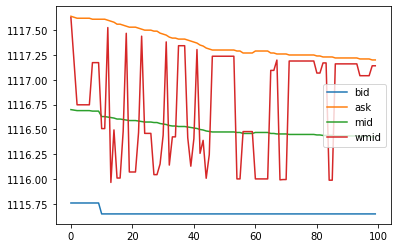

In [41]:
data[['bid','ask','mid','wmid']].iloc[:100].plot()

# The mid vs. the weighted mid

The mid-price:
- Not a martingale (Bid-ask bounce)
- Medium frequency signal 
- Doesn't use volume at the best bid and ask prices. 

The weighted mid-price:
- Uses the volume at the best bid and ask prices.
- High frequency signal
- Is quite noisy, particularly when the spread widens to two ticks


# Desirable features of the Micro-Price

 $P_t^{micro}=F(M_t,I_t,S_t) = M_t+ G(I_t,S_t)$ 
- Martingale
- Computationally fast
- Better short term price predictions than the midprice or weighted midprice
- Should work for large tick stocks (like BAC) or small tick stocks (like CVX)

# Outline

1. General definition
2. A discrete Markov model
3. Data analysis
4. Conclusion

# Micro-price definition

Define
\begin{equation*}
P_t^{micro}=\lim_{n\to\infty} P_t^n
\end{equation*}
where the approximating sequence of martingale prices is given by
$$P^n_t=\mathbb{E} \left[  M_{\tau_n} |  I_t,S_t \right] $$

$\tau_1,...,\tau_n$ are (random) times when the mid-price $M_t$ changes
 
The micro-price is the expected mid-price in the distant future
 
In practice, the distant future is well captured by $P_t^6$, the expected mid price after 6 price moves.

# Main result


The $i$-th approximation to the micro-price can be written as
\begin{equation*}
P_t^{n} =  M_t + \sum_{k=1}^{n}g^k(I_t,S_t) 
\end{equation*}
where
$$g^1(I_t,S_t)= \mathbb{E}  \left[  M_{\tau_1} - M_t  | I_t, S_t \right] $$
and
$$
g^{n+1}(I_t,S_t)= \mathbb{E}\left[ g^n(I_{\tau_{1}},S_{\tau_{1}}) | I_{t},S_t\right], \forall j\geq 0
$$
can be computed recursively.

# Finite state Markov chain

- The imbalance takes discrete values $1\leq i_I \leq n$, 
- The spread takes discrete values $1\leq i_S \leq m$
- The mid-price changes takes values in $K =[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]$. 
- Define the state $X_t=(I_t,S_t)$ with discrete values $1\leq i \leq nm$

# Computing $g^1$

The first step approximation to the micro-price 
\begin{align*}
g^1(i) = &  \mathbb{E} \left[M_{\tau_{1}}- M_{t} | X_t= i \right] \\
= {}& \big(1-Q\big)^{-1}R^1\underline{k}
\end{align*}

Where
$$Q_{ij} := \mathbb{P}(M_{t+1}- M_t =0 \wedge X_{t+1}=j | X_t= i)$$
are the transition probabilities for transient states (mid price does not move) 

$$R^1_{ik} := \mathbb{P}(M_{t+1}- M_t =k | X_t = i)$$ are the transition probabilities into absorbing states (mid price does move) 

and $$\underline{k}=[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]^T$ 

# Computing $g^{i+1}$


We can compute recursively
\begin{align*}
g^{n+1}=  B g^n
\end{align*}
where $B:=\big(1-Q\big)^{-1}R^2$

and $R^2$ is a new matrix of absorbing states
\begin{align*}
R^2_{ik} := {}& \mathbb{P}(M_{t+1}- M_t \neq 0 \wedge I_{t+1}=k  | I_t = i)
\end{align*}

# Does the micro-price converge?

Yes. But we have to appropriately symmetrize the data.

Technical conditions are available in the paper.

# Data analysis on BAC and CVX

# Estimation

1. On every quote, compute $I_t, S_t, (M_{t+1}-M_t)$, after having discretized the state space
2. Symmetrize the data, by making a copy where $I^2_t=n-I_t, S^2_t=S_t, (M^2_{t+1}-M^2_t)=-(M_{t+1}-M_t)$
3. Estimate transition probability matrices $Q, R^1, R^2$


# Computation

Compute the first micro-price adjustment:
$$p^{1}-M = g^1 = \big(1-Q\big)^{-1}R^1\underline{k}$$
Use our recursive formula to compute the 6th micro-price adjustment:
$$p^{6}-M = g^1+g^2+ \ldots +g^6 = g^1 + B g^1 + \ldots + B^5 g^1 $$
In practice this converges after 6 price moves

In [42]:
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [43]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread=T.ask-T.bid
    ticksize=np.round(min(spread.loc[spread>0])*100)/100
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    print(T)
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'], bins = pd.qcut(T['imb'], n_imb, labels=False, retbins = True)
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize,bins

In [44]:
def estimate(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    print(no_move_counts)
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    K=np.array([-0.01, -0.005, 0.005, 0.01])
    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [45]:
def plot_Gstar(ticker,G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick adj",marker='o')
    plt.ylim(-0.25,0.25)
    # plt.legend(loc='upper left')
    plt.title(ticker+' adjustments')
    plt.xlabel('Imbalance')
    plt.legend('',frameon=False)
    return G6

In [46]:
def market_order(O, side, dollar_value,i):
    side = "ask" if side == "buy" else "bid"
    total_price = 0
    total_qty = 0
    row = O.loc[i]
    for i in range(20):
        if(total_price < dollar_value):
            total_price += float(row[side+"_"+str(i)+"_px"]) * float(row[side+"_"+str(i)+"_qty"])
            total_qty += float(row[side+"_"+str(i)+"_qty"])
            last = i            
                
    if total_price >= dollar_value:
        extra = total_price - dollar_value
        total_qty = total_qty - extra / float(row[side+"_"+str(last)+"_px"])
    else:
        extra = dollar_value - total_price
        total_qty = total_qty + extra / float(row[side+"_"+str(last)+"_px"])

    #         print(total_price)  
    avg_price = dollar_value / total_qty
    market_avg_price = avg_price
    return market_avg_price

# Calculating G6


In [47]:
n_imb=current_test[3]
n_spread=500
dt=1
data=get_df(current_test[0]) 
ticker='GRAIL-USDT'
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
T,ticksize,bins=prep_data_sym(data,n_imb,dt,n_spread)

ticksize




       date          time      bid      bs      ask      as       mid  \
0       1.0  1.681261e+12  1115.76  0.5470  1117.64  0.0042  1116.700   
1       1.0  1.681261e+12  1115.76  0.5470  1117.63  0.1692  1116.695   
2       1.0  1.681261e+12  1115.76  0.5470  1117.62  0.4823  1116.690   
3       1.0  1.681261e+12  1115.76  0.5470  1117.62  0.4823  1116.690   
4       1.0  1.681261e+12  1115.76  0.5470  1117.62  0.4823  1116.690   
...     ...           ...      ...     ...      ...     ...       ...   
22231   1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0078  1112.105   
22232   1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0066  1112.105   
22233   1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0078  1112.105   
22234   1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0066  1112.105   
22235   1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0066  1112.105   

            imb         wmid  spread  
0      0.992380  1117.625675    1.88  
1      0.763753  1117.188218    1.87  
2     

0.01

In [48]:
ticksize_test = ticksize

In [49]:
bins_test = bins

spread  imb_bucket  next_imb_bucket
0.01    0           0.0                593
                    1.0                  0
                    2.0                  0
                    3.0                  0
                    4.0                  0
                                      ... 
3.67    9           5.0                  0
                    6.0                  0
                    7.0                  0
                    8.0                  0
                    9.0                  2
Length: 22960, dtype: int64


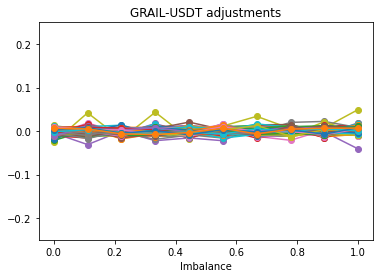

In [50]:
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)
G6=plot_Gstar(ticker,G1,B,T)

Text(0.5, 0, 'Imbalance')

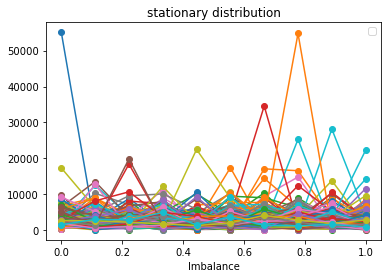

In [51]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend('', frameon = 'False')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

In [52]:
def prep_data_sym_test(T,n_imb,dt,n_spread,ticksize):
    spread=T.ask-T.bid
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    print(T)
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'], bins = pd.qcut(T['imb'], n_imb, labels=False, retbins = True)
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize,bins

In [53]:
data=get_df(current_test[1]) 
ticker='GRAIL-USDT'
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
T,ticksize,bins=prep_data_sym_test(data,n_imb,dt,n_spread,ticksize_test)

       date          time      bid      bs      ask      as       mid  \
0       1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0066  1112.105   
1       1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0078  1112.105   
2       1.0  1.681265e+12  1111.11  0.0131  1113.10  0.0066  1112.105   
3       1.0  1.681265e+12  1111.11  0.0131  1113.09  0.3770  1112.100   
4       1.0  1.681265e+12  1111.11  0.0131  1113.08  0.3946  1112.095   
...     ...           ...      ...     ...      ...     ...       ...   
23166   1.0  1.681268e+12  1095.60  0.0227  1097.76  0.2070  1096.680   
23167   1.0  1.681268e+12  1095.60  0.0227  1097.75  0.0237  1096.675   
23168   1.0  1.681268e+12  1095.60  0.0227  1097.75  0.0054  1096.675   
23169   1.0  1.681268e+12  1095.61  0.0756  1097.75  0.0054  1096.680   
23170   1.0  1.681268e+12  1095.64  0.0227  1097.75  0.0054  1096.695   

            imb         wmid  spread  
0      0.664975  1112.433299    1.99  
1      0.626794  1112.357321    1.99  
2     

In [54]:
T=T.drop_duplicates("time")
T["imb_bucket"] = pd.cut(T.imb, 
                            bins=bins_test, 
                            labels=list(range(0,n_imb)))

T["timestamp"] = T["time"]

In [55]:
order = pd.read_csv(current_test[2]) #copy 2

In [56]:
order

,Unnamed: 0,timestamp,market_id,market,symbol,ask_0_px,ask_1_px,ask_2_px,ask_3_px,ask_4_px,...,bid_11_qty,bid_12_qty,bid_13_qty,bid_14_qty,bid_15_qty,bid_16_qty,bid_17_qty,bid_18_qty,bid_19_qty,date
0,0,1.681265e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1113.10,1113.11,1113.13,1113.19,1113.28,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
1,1,1.681265e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1113.10,1113.11,1113.13,1113.19,1113.28,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
2,2,1.681265e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1113.10,1113.11,1113.13,1113.19,1113.28,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
3,3,1.681265e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1113.09,1113.12,1113.13,1113.19,1113.28,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
4,4,1.681265e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1113.08,1113.09,1113.19,1113.28,1113.46,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,23166,1.681268e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1097.76,1097.77,1097.78,1098.13,1098.91,...,0.5418,0.4171,0.0010,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,1
23167,23167,1.681268e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1097.75,1097.76,1097.78,1098.13,1098.91,...,0.5418,0.4171,0.0010,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,1
23168,23168,1.681268e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1097.75,1097.76,1097.78,1098.91,1100.04,...,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,0.9133,0.0099,0.0012,1
23169,23169,1.681268e+12,1,GT-YFII-USDT-SPOT,YFII-USDT,1097.75,1097.78,1098.91,1100.03,1100.04,...,0.0010,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,0.9133,0.0099,1


In [57]:
s1 = pd.merge(T, order, how='inner', on=['timestamp'])

In [58]:
s1 = s1.dropna()

In [59]:
T.reset_index(drop=True,inplace=True)
s1.reset_index(drop=True,inplace=True)

In [60]:
s1

,date_x,time,bid,bs,ask,as,mid,imb,wmid,spread,...,bid_11_qty,bid_12_qty,bid_13_qty,bid_14_qty,bid_15_qty,bid_16_qty,bid_17_qty,bid_18_qty,bid_19_qty,date_y
0,1.0,1.681265e+12,1111.11,0.0131,1113.10,0.0066,1112.105,0.664975,1112.433299,1.99,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
1,1.0,1.681265e+12,1111.11,0.0131,1113.10,0.0078,1112.105,0.626794,1112.357321,1.99,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
2,1.0,1.681265e+12,1111.11,0.0131,1113.10,0.0066,1112.105,0.664975,1112.433299,1.99,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
3,1.0,1.681265e+12,1111.11,0.0131,1113.09,0.3770,1112.100,0.033581,1111.176491,1.98,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
4,1.0,1.681265e+12,1111.11,0.0131,1113.08,0.3946,1112.095,0.032131,1111.173299,1.97,...,0.0012,0.5418,0.4171,0.0097,0.0012,0.8998,0.1876,0.0011,0.0010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22363,1.0,1.681268e+12,1095.60,0.0227,1097.77,0.0291,1096.685,0.438224,1096.550946,2.17,...,0.5418,0.4171,0.0010,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,1
22364,1.0,1.681268e+12,1095.60,0.0227,1097.76,0.2070,1096.680,0.098825,1095.813461,2.16,...,0.5418,0.4171,0.0010,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,1
22365,1.0,1.681268e+12,1095.60,0.0227,1097.76,0.2070,1096.680,0.098825,1095.813461,2.16,...,0.5418,0.4171,0.0010,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,1
22366,1.0,1.681268e+12,1095.60,0.0227,1097.75,0.0237,1096.675,0.489224,1096.651832,2.15,...,0.5418,0.4171,0.0010,0.0071,0.0017,0.5356,1.0539,0.0010,0.0012,1


In [61]:
# working - range - 0,3000, data - test 1(5) testing data test1(4) train, diff<0.3 , diff<0.9, order =  s1, sell, 30,i
# prev = 30
k = []
d = []
placed_sell = 0
filled_sell = 0
placed_buy = 0
filled_buy = 0
import random
interval = 100
twap = []
ls = []
q_twap = 0
for i in range(0,21000,interval):
    s = int(s1.loc[i,'spread']/ticksize)
    imbb = int(s1.loc[i, "imb_bucket"])
    # print(s,imbb)
    required_g6 = G6[(0+(s-1)*n_imb):(n_imb+(s-1)*n_imb)]
    normal_G6 = [(float(i)-min(required_g6))/(max(required_g6)-min(required_g6)) for i in required_g6]
    diff = normal_G6[imbb]
    # print(normal_G6)
    twap.append(market_order(s1, "sell", 50, i))
    print("twap")
    print(market_order(s1, "sell", 50, i))
    # if(diff<0.3):
    #     k.append(market_order(s1, "sell", 30, i))
    #     print("mp")
    #     print(market_order(s1, "sell", 30, i)) 
    #     # placed_sell+=1
    #     # if(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,'bid']>=0.05):
    #     #     filled_sell+=1
    #     #     ls.append(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,"bid"])
    #     #     k.append(max(T.loc[i+1:i+interval,"bid"].to_list()))
    #     #     print("mp")
    #     #     print(max(T.loc[i+1:i+interval,"bid"].to_list()))
    #     #     d.append(diff)
    #     # else:
    #     #     k.append(market_order(s1, "sell", 5, i+interval))
    #     #     print("mp")
    #     #     print(market_order(s1, "sell", 5, i+interval))   
    # else:
    if(diff>0.5):
        placed_sell+=1
        if(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,'bid']>=0.01):
            filled_sell+=1
            ls.append(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,"bid"])
            k.append(max(T.loc[i+1:i+interval,"bid"].to_list()))
            print("mp")
            print(max(T.loc[i+1:i+interval,"bid"].to_list()))
            d.append(diff)
        else:
            k.append(market_order(s1, "sell", 50, i+interval))
            print("mp")
            print(market_order(s1, "sell", 50, i+interval)) 
    else:
        k.append(market_order(s1, "sell", 50, i))
        print("mp")
        print(market_order(s1, "sell", 50, i)) 
        # k.append(market_order(s1, "sell", 5, i))
        # print("mp")
        # print(market_order(s1, "sell", 5, i)) 
        # placed_buy+=1
        # if(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask']>=0.1):
        #     filled_buy+=1
        #     k.append(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask'])
        #     d.append(diff)


twap
1111.1029110896266
mp
1111.1029110896266
twap
1110.5211771524475
mp
1109.49173146352
twap
1109.49173146352
mp
1109.49173146352
twap
1109.6031327495416
mp
1109.612089981639
twap
1109.612089981639
mp
1109.612089981639
twap
1109.6018813490991
mp
1109.7487448201096
twap
1109.7487448201096
mp
1110.22
twap
1109.937147995233
mp
1109.937147995233
twap
1110.25
mp
1110.79
twap
1110.5849309970934
mp
1110.5849309970934
twap
1110.2249293986872
mp
1110.27
twap
1109.8735515953645
mp
1109.8735515953645
twap
1109.7395659550573
mp
1109.5700915408825
twap
1109.5700915408825
mp
1109.5700915408825
twap
1109.558007692642
mp
1110.16
twap
1110.174929176685
mp
1110.48
twap
1110.47135477505
mp
1110.5
twap
1110.0349285550828
mp
1110.0349285550828
twap
1109.406217863036
mp
1109.406217863036
twap
1109.4441480606415
mp
1109.4441480606415
twap
1109.4660946057431
mp
1109.4660946057431
twap
1109.4840096815885
mp
1109.4840096815885
twap
1109.5158086451725
mp
1109.5158086451725
twap
1109.6591265808045
mp
1109.01069

In [62]:
filled_sell/placed_sell

0.5416666666666666

In [63]:
sum(k)/len(k)

1099.3523340933548

In [64]:
sum(twap)/len(twap)

1099.3166447327435

7.494765728372386


<function matplotlib.pyplot.show(close=None, block=None)>

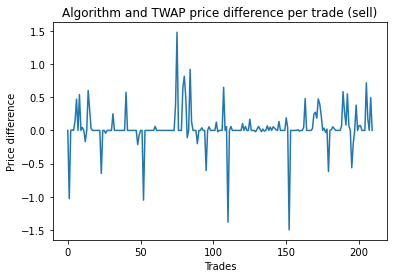

In [65]:
a = [x1 - x2 for (x1, x2) in zip(k,twap)]
print(sum(a))
plt.plot(list(range(0,210)), a)
# plt.plot(list(range(0,210)), k, '-.')
plt.xlabel("Trades")
plt.ylabel("Price difference")
plt.title("Algorithm and TWAP price difference per trade (sell)")
plt.show

In [66]:
# working - range - 0,3000, data - test 1(5) testing data test1(4) train, diff<0.3 , diff<0.9, order =  s1, sell, 30,i, interval = 6
k = []
d = []
placed_sell = 0
filled_sell = 0
placed_buy = 0
filled_buy = 0
import random
interval = 100
twap = []
ls = []
q_twap = 0
for i in range(0,21000,interval):
    s = int(s1.loc[i,'spread']/ticksize)
    imbb = int(s1.loc[i, "imb_bucket"])
    # print(s,imbb)
    required_g6 = G6[(0+(s-1)*n_imb):(n_imb+(s-1)*n_imb)]
    normal_G6 = [(float(i)-min(required_g6))/(max(required_g6)-min(required_g6)) for i in required_g6]
    diff = normal_G6[imbb]
    # print(normal_G6)
    twap.append(market_order(s1, "buy", 50, i))
    print("twap")
    print(market_order(s1, "buy", 50, i))
    if(diff<0.5):
        # k.append(market_order(s1, "sell", 30, i))
        # print("mp")
        # print(market_order(s1, "sell", 30, i)) 
        placed_buy+=1
        if(-min(T.loc[i+1:i+interval,"ask"].to_list())+T.loc[i,'ask']>=0.05):
            filled_buy+=1
            ls.append(-min(T.loc[i+1:i+interval,"ask"].to_list())+T.loc[i,"ask"])
            k.append(min(T.loc[i+1:i+interval,"ask"].to_list()))
            print("mp")
            print(min(T.loc[i+1:i+interval,"ask"].to_list()))
            d.append(diff)
        else:
            k.append(market_order(s1, "buy", 50, i+interval))
            print("mp")
            print(market_order(s1, "buy", 50, i+interval))   
    else:
        # if(diff>0.9):
        #     placed_sell+=1
        #     if(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,'bid']>=0.05):
        #         filled_sell+=1
        #         ls.append(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,"bid"])
        #         k.append(max(T.loc[i+1:i+interval,"bid"].to_list()))
        #         print("mp")
        #         print(max(T.loc[i+1:i+interval,"bid"].to_list()))
        #         d.append(diff)
        #     else:
        #         k.append(market_order(s1, "sell", 30, i+interval))
        #         print("mp")
        #         print(market_order(s1, "sell", 30, i+interval)) 
        # else:
        #     k.append(market_order(s1, "sell", 30, i))
        #     print("mp")
        #     print(market_order(s1, "sell", 30, i)) 
        k.append(market_order(s1, "buy", 50, i))
        print("mp")
        print(market_order(s1, "buy", 50, i)) 
        # placed_buy+=1
        # if(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask']>=0.1):
        #     filled_buy+=1
        #     k.append(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask'])
        #     d.append(diff)


twap
1113.1085306967382
mp
1112.59
twap
1112.5899999999995
mp
1112.5899999999995
twap
1111.8300000000004
mp
1111.3
twap
1112.7499999999995
mp
1112.7499999999995
twap
1112.36
mp
1112.1
twap
1112.0999999999997
mp
1112.0999999999997
twap
1111.6959089590557
mp
1111.6959089590557
twap
1112.3527029662685
mp
1112.2
twap
1112.205907082262
mp
1112.205907082262
twap
1112.6644366778178
mp
1112.17
twap
1112.1761741139615
mp
1112.1761741139615
twap
1111.7682656415054
mp
1111.55
twap
1113.3100000000004
mp
1113.3100000000004
twap
1112.6527677570075
mp
1112.28
twap
1112.2627702919933
mp
1112.2627702919933
twap
1112.6700000000003
mp
1112.6700000000003
twap
1112.228264923908
mp
1112.228264923908
twap
1111.9155300995699
mp
1111.43
twap
1111.4993461133313
mp
1111.37
twap
1111.6100000000001
mp
1111.48
twap
1111.7155531377866
mp
1111.6276413267865
twap
1111.6276413267865
mp
1111.43
twap
1111.434606099232
mp
1112.750000000001
twap
1112.750000000001
mp
1112.750000000001
twap
1111.8500000000008
mp
1111.05
twap

In [67]:
filled_buy/placed_buy

0.7894736842105263

In [68]:
sum(k)/len(k)

1101.884377056015

In [69]:
sum(twap)/len(twap)

1102.0795470378491

-40.985696185133975


<function matplotlib.pyplot.show(close=None, block=None)>

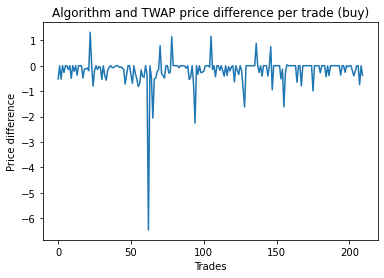

In [70]:
a = [x1 - x2 for (x1, x2) in zip(k,twap)]
print(sum(a))
plt.plot(list(range(0,210)), a)
# plt.plot(list(range(0,210)), k, '-.')
plt.xlabel("Trades")
plt.ylabel("Price difference")
plt.title("Algorithm and TWAP price difference per trade (buy)")
plt.show



# Summary

1. The micro-price is the expected mid-price in the distant future
2. In practice, the distant future is adequately approximated by $\tau^6$ the time of the 6th mid price move
3. Paper provides evidence that the micro-price is a good predictor of future mid prices
3. Micro-price can fit very different microstructures
4. Micro-price is horizon independent
5. Micro-price seems to live between the bid and the ask